### 1. Import libraries

In [66]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
import time

### 2. Load and Preprocess data

In [67]:
# Choose the number of features to use for training
num_features = 4
cross_validation_folds = 2
# Load the dataset
heart_df = pd.read_csv('datasets/heart.csv', delimiter=',')
heart_df.head()

# Convert categorical columns to strings
string_col = heart_df.select_dtypes(include="object").columns
heart_df[string_col] = heart_df[string_col].astype("string")

# Encode categorical columns
label_encoders = {}
for column in heart_df.columns:
    if heart_df[column].dtype == 'string':
        le = LabelEncoder()
        heart_df[column] = le.fit_transform(heart_df[column])
        label_encoders[column] = le

# Create a copy of the dataframe for visualization
plot_df = heart_df.copy()

### 3. Feature Selection

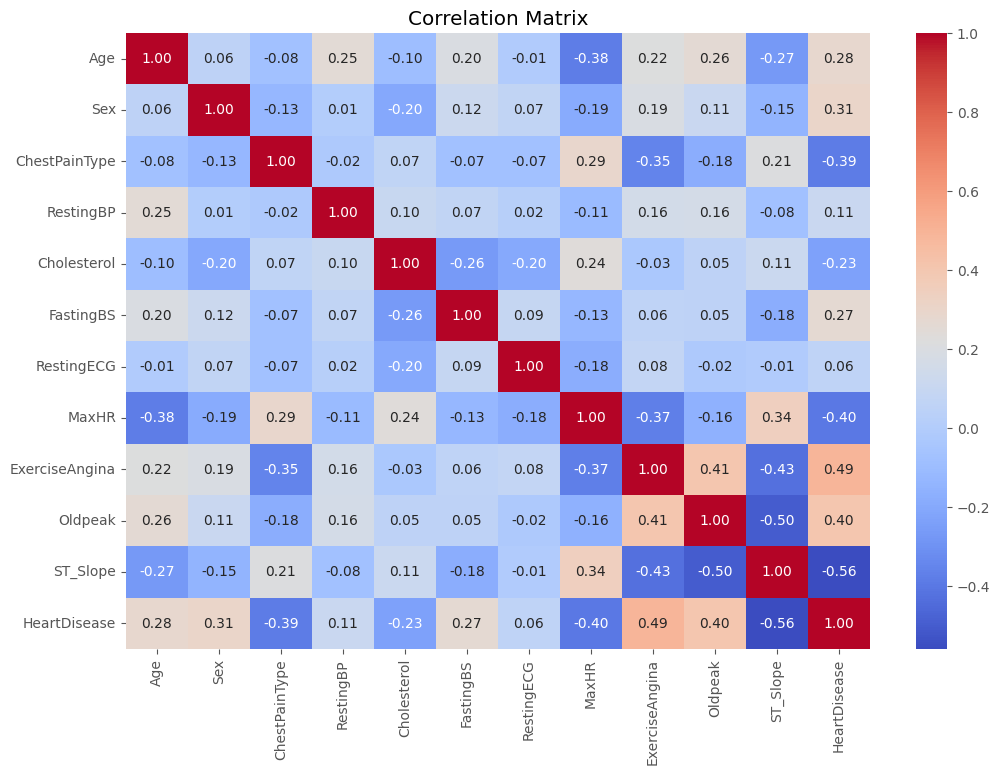

HeartDisease      1.000000
ExerciseAngina    0.494282
Oldpeak           0.403951
Sex               0.305445
Age               0.282039
FastingBS         0.267291
RestingBP         0.107589
RestingECG        0.057384
Cholesterol      -0.232741
ChestPainType    -0.386828
MaxHR            -0.400421
ST_Slope         -0.558771
Name: HeartDisease, dtype: float64


In [68]:
# Compute correlation matrix
corr_matrix = heart_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Check correlation with the target variable
print(corr_matrix["HeartDisease"].sort_values(ascending=False))

In [69]:
# Let the user choose the number of features
if num_features > len(heart_df.columns) - 1:  # Exclude target column
    raise ValueError("Number of features exceeds available features.")

# Select top `num_features` based on correlation with the target
target = "HeartDisease"
corr = heart_df.corr()[target].abs().sort_values(ascending=False)
selected_features = corr.index[1:num_features + 1].tolist()

# Prepare the dataset with selected features
X = heart_df[selected_features].values
y = heart_df[target].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### 4. Exploratory Data Analysis (EDA)

<Figure size 1500x1000 with 0 Axes>

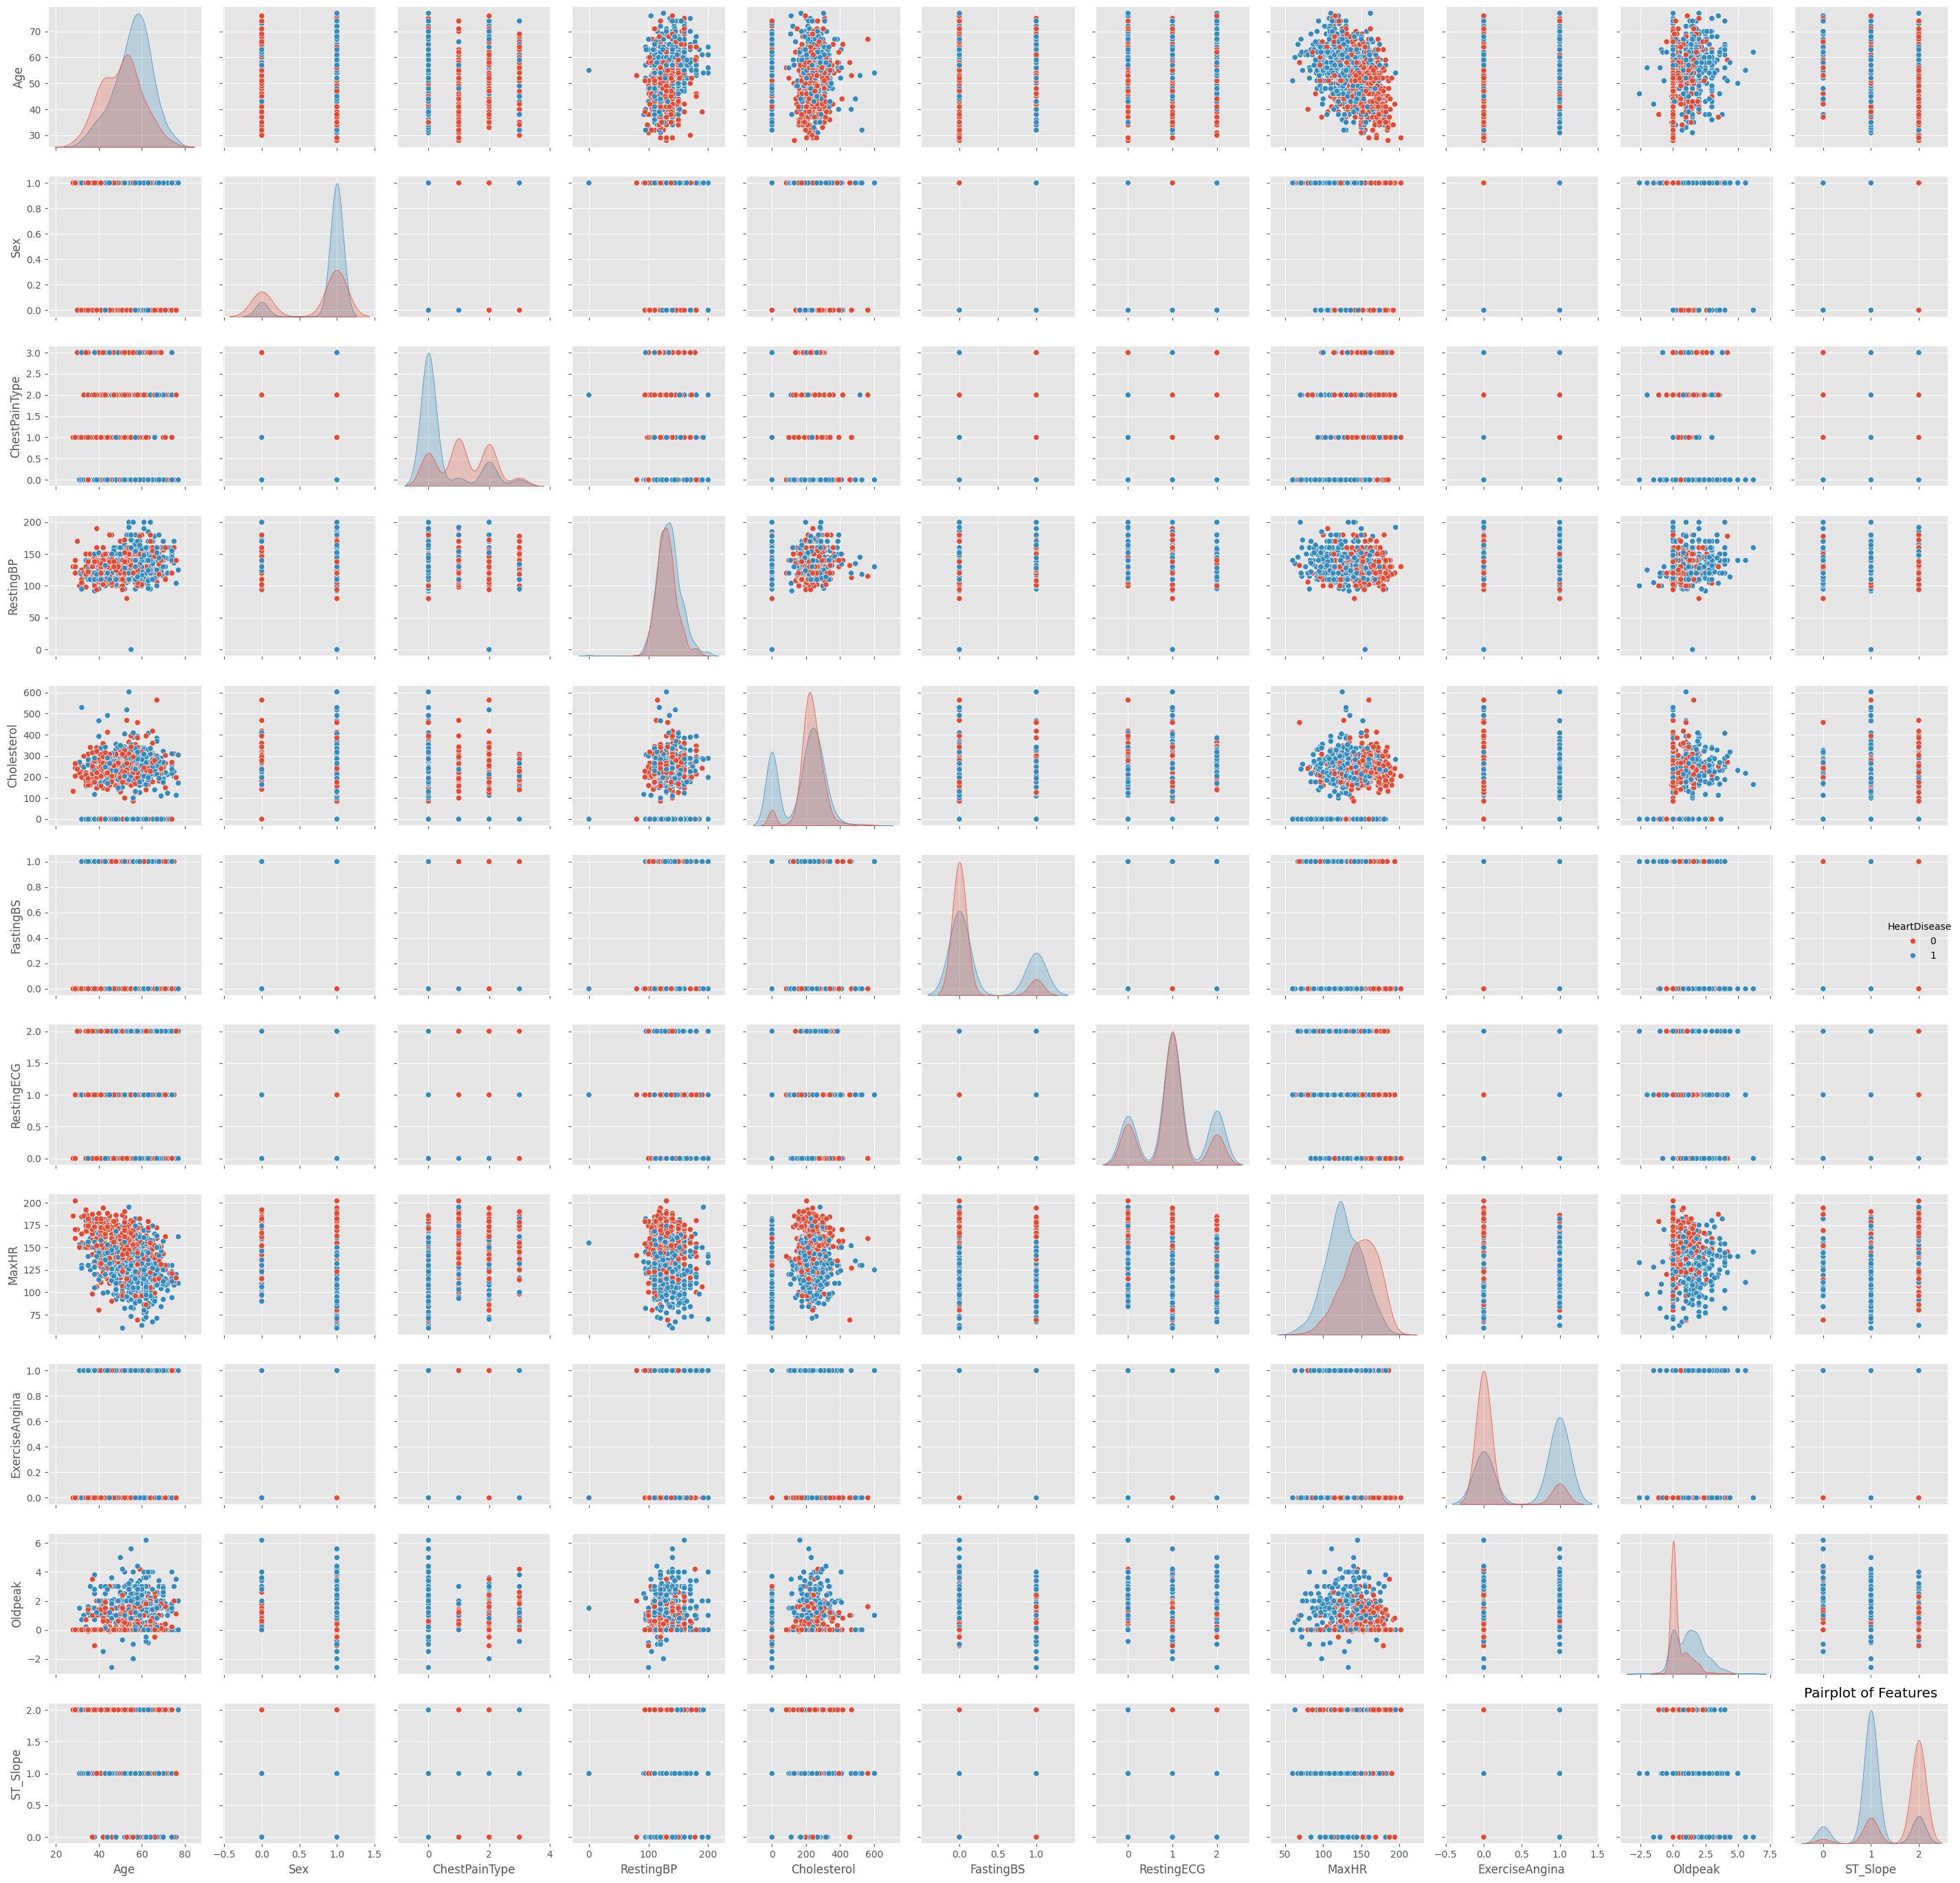

In [70]:
# Correlation Matrix
px.imshow(heart_df.corr(), title="Correlation Plot of the Heart Failure Prediction")

# Distribution of Heart Diseases
fig = px.histogram(heart_df, x="HeartDisease", color="Sex", hover_data=heart_df.columns,
                title="Distribution of Heart Diseases", barmode="group")
fig.show()

# Pairplot
plt.figure(figsize=(15, 10))
sns.pairplot(plot_df, hue="HeartDisease")
plt.title("Pairplot of Features")
plt.tight_layout()
plt.show()

### 5. Classical Machine Learning Models

In [71]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "SVM (Linear Kernel)": SVC(kernel="linear"),
    "SVM (RBF Kernel)": SVC(kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=32),
}

# Cross-validation and evaluation
kf = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True, random_state=42)
results = {}

for model_name, model in models.items():
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = roc_auc_score(y_val, y_pred)
        fold_scores.append(score)

    results[model_name] = np.mean(fold_scores)
    print(f"{model_name} - Average ROC AUC Score: {results[model_name]:.4f}")

Logistic Regression - Average ROC AUC Score: 0.8076
Naive Bayes - Average ROC AUC Score: 0.8026
SVM (Linear Kernel) - Average ROC AUC Score: 0.8098
SVM (RBF Kernel) - Average ROC AUC Score: 0.8061
K-Nearest Neighbors - Average ROC AUC Score: 0.8064


### 6. Quantum Machine Learning Model

In [72]:
# Initialize quantum components
feature_map = ZZFeatureMap(feature_dimension=X.shape[1], reps=1)
ansatz = RealAmplitudes(num_qubits=X.shape[1], reps=3)
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

# Cross-validation for quantum model
quantum_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
    )

    vqc.fit(X_train, y_train)
    score = vqc.score(X_val, y_val)
    quantum_scores.append(score)
    print(f"Fold {fold + 1} - Quantum VQC Score: {score:.4f}")

quantum_avg_score = np.mean(quantum_scores)
results["Quantum VQC"]=quantum_avg_score
print(f"Quantum VQC - Average ROC AUC Score: {quantum_avg_score:.4f}")

Fold 1 - Quantum VQC Score: 0.7952
Fold 2 - Quantum VQC Score: 0.7952
Quantum VQC - Average ROC AUC Score: 0.7952


In [73]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save your API token (only need to do this once)
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="api", overwrite=True)

# Load the saved account
service = QiskitRuntimeService()

In [ ]:
service = QiskitRuntimeService(instance="ibm-q/open/main")

service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_kyiv')>]

In [75]:
backend = service.least_busy(operational=True, min_num_qubits=5)

In [76]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import Session, Options

# Define feature map and ansatz
feature_map = ZZFeatureMap(feature_dimension=X.shape[1], reps=1)
ansatz = RealAmplitudes(num_qubits=X.shape[1], reps=1)  # Use fewer reps for real hardware

# Set up optimizer
optimizer = COBYLA(maxiter=50)  # Reduce maxiter for faster execution

# Set up runtime options
options = Options()
options.execution.shots = 1024  # Number of shots
options.optimization_level = 3  # Highest optimization level
options.resilience_level = 1  # Enable basic error mitigation

# Initialize VQC
vqc = VQC(
    sampler=Sampler(),
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
)

# Run on real hardware
with Session(service=service, backend=backend):
    print("Training on real quantum hardware...")
    start_time = time.time()
    vqc.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    # Evaluate the model
    train_score = vqc.score(X_train, y_train)
    test_score = vqc.score(X_val, y_val)
    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
results["Real Quantum VQC"]=test_score

Training on real quantum hardware...
Training completed in 23.36 seconds.
Training Score: 0.7756
Test Score: 0.7516


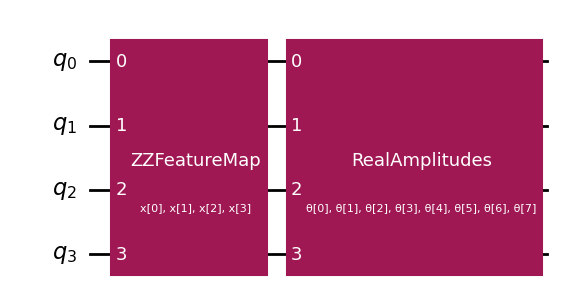

In [77]:
vqc.circuit.draw(output='mpl')

### 7. Results and Comparison

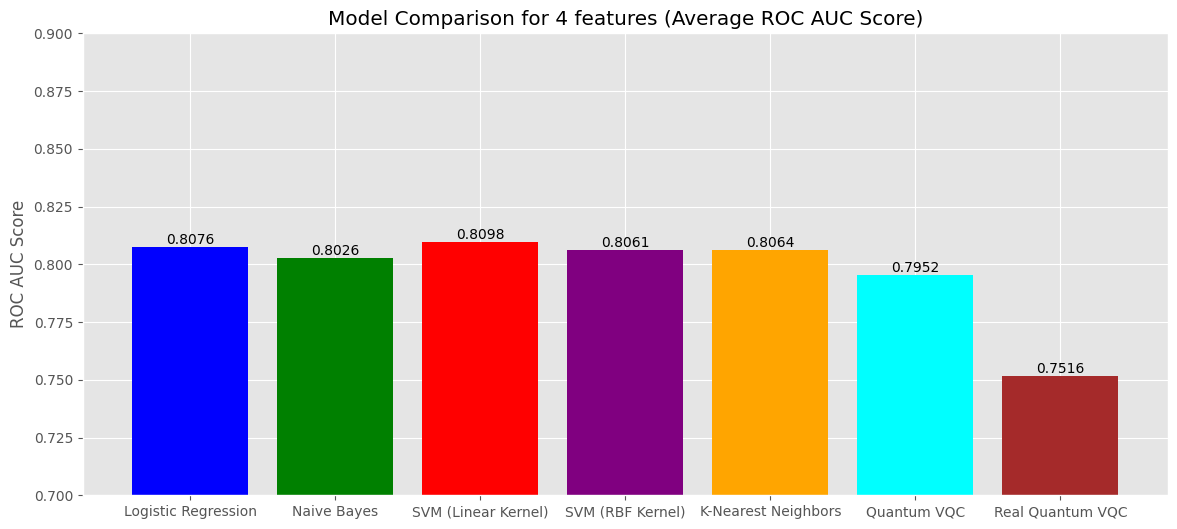

In [81]:
# Bar plot with annotations
plt.figure(figsize=(14, 6))
bars = plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'brown'])
plt.title(f"Model Comparison for {num_features} features (Average ROC AUC Score)")
plt.ylabel("ROC AUC Score")
plt.ylim(0.70, 0.90)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}", ha='center', va='bottom')
plt.show()

